In [27]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, accuracy_score,
                             precision_score, recall_score, f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import joblib
from pptx import Presentation
from pptx.util import Inches

In [28]:
# ---------- CONFIG ----------
DATA_PATH = "../data/IBM-HR-Employee-Attrition.csv"
RESULT_DIR = "../result/hr_attrition"
FIG_DIR = os.path.join(RESULT_DIR, "figures")
MODEL_DIR = os.path.join(RESULT_DIR, "models")
TABLE_DIR = os.path.join(RESULT_DIR, "tables")
PPTX_PATH = os.path.join(RESULT_DIR, "HR_Attrition_Report.pptx")
RANDOM_STATE = 42
# ----------------------------
# create directories
for d in [RESULT_DIR, FIG_DIR, MODEL_DIR, TABLE_DIR]:
    Path(d).mkdir(parents=True, exist_ok=True)

# Load data
df = pd.read_csv(DATA_PATH)
# quick save head
df.head().to_csv(os.path.join(TABLE_DIR, "head.csv"), index=False)


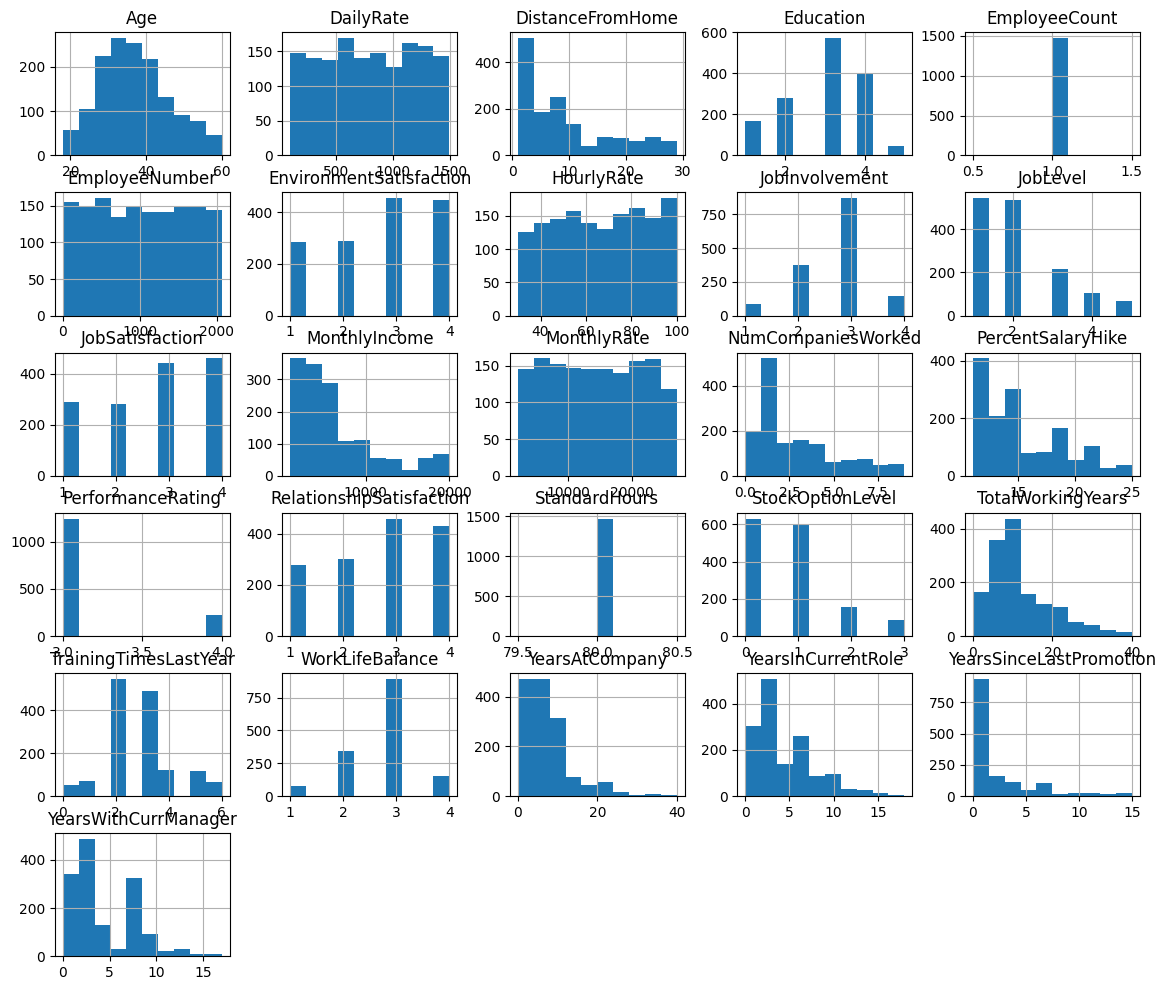

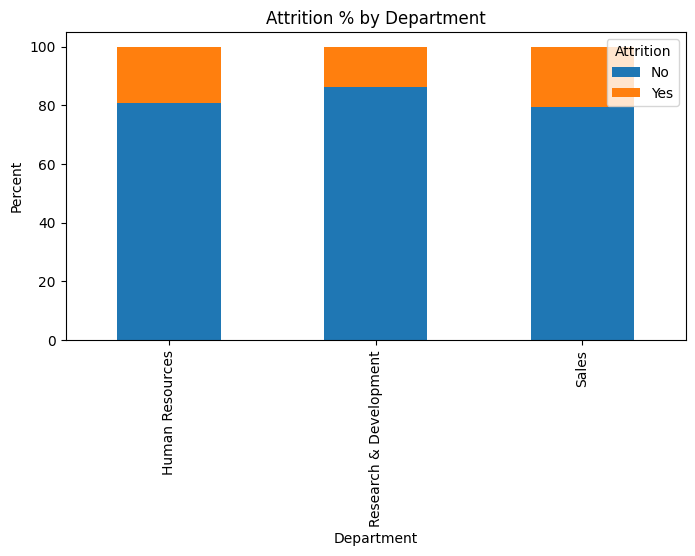

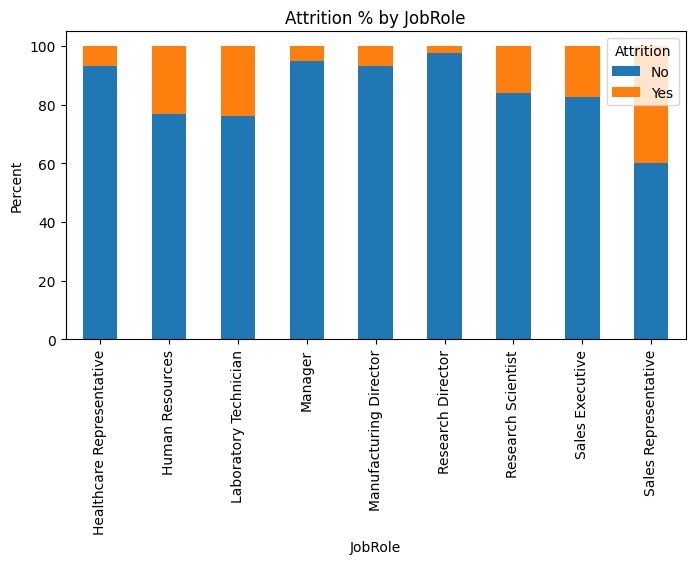

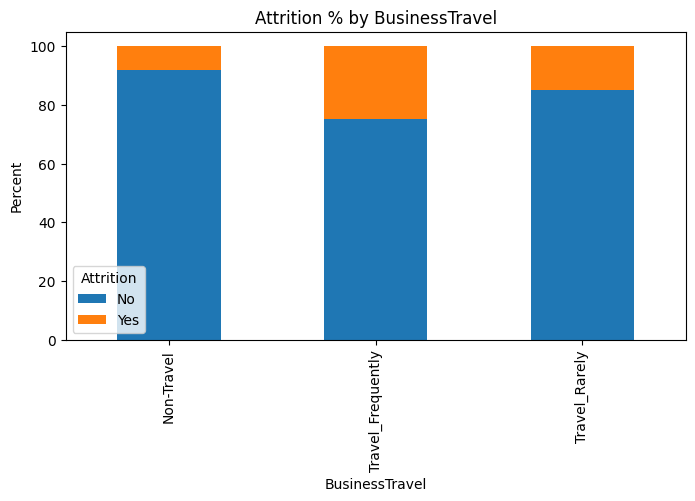

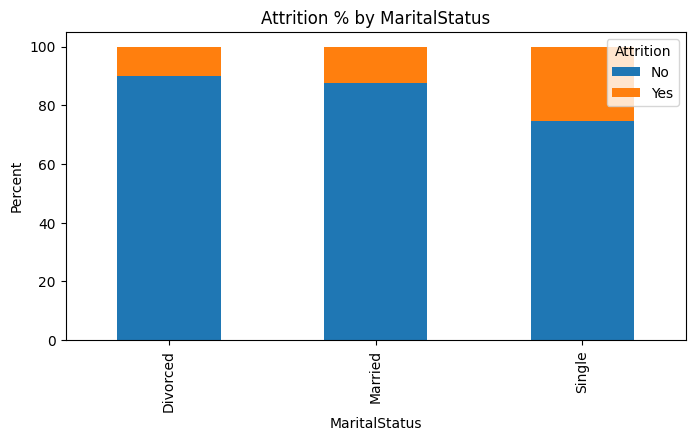

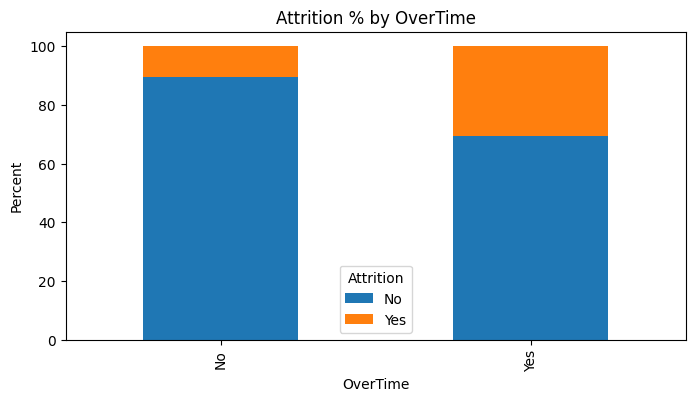

In [29]:
# ---------- EDA ----------
def save_fig(fig, name, dpi=150):
    path = os.path.join(FIG_DIR, name)
    fig.savefig(path, bbox_inches="tight", dpi=dpi)
    plt.close(fig)

# 1) Basic info
info = {
    "shape": df.shape,
    "columns": list(df.columns),
    "dtypes": df.dtypes.astype(str).to_dict(),
    "missing_values": df.isna().sum().to_dict(),
    "value_counts_attrition": df["Attrition"].value_counts().to_dict()
}
pd.Series(info).to_json(os.path.join(TABLE_DIR, "dataset_summary.json"))

# 2) Attrition distribution
fig = plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Attrition")
plt.title("Attrition Count")
save_fig(fig, "attrition_count.png")

# 3) Numerical distributions: histograms for numeric columns
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
fig = plt.figure(figsize=(14, 8))
df[num_cols].hist(figsize=(14, 12))
save_fig(fig, "numerical_histograms.png")

# 4) Boxplots of a selection numeric vs Attrition (examples)
for col in ["Age", "DistanceFromHome", "MonthlyIncome", "TotalWorkingYears", "YearsAtCompany"]:
    if col in df.columns:
        fig = plt.figure(figsize=(6,4))
        sns.boxplot(data=df, x="Attrition", y=col)
        plt.title(f"{col} by Attrition")
        save_fig(fig, f"boxplot_{col}_by_attrition.png")

# 5) Categorical relationships: e.g., Department, JobRole, BusinessTravel
cat_cols = df.select_dtypes(include=["object"]).columns.drop("Attrition").tolist()
for col in ["Department", "JobRole", "BusinessTravel", "MaritalStatus", "OverTime"]:
    if col in df.columns:
        fig = plt.figure(figsize=(8,4))
        prop = (pd.crosstab(df[col], df["Attrition"], normalize="index") * 100)
        prop.plot(kind="bar", stacked=True, figsize=(8,4))
        plt.title(f"Attrition % by {col}")
        plt.ylabel("Percent")
        save_fig(fig, f"attrition_by_{col}.png")

# 6) Correlation heatmap (numeric)
corr = df[num_cols].corr()
fig = plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Numeric Correlation Matrix")
save_fig(fig, "correlation_matrix.png")
corr.to_csv(os.path.join(TABLE_DIR, "numeric_correlation.csv"))


In [30]:
# ---------- Prepare data for modeling ----------
# Target
y = (df["Attrition"] == "Yes").astype(int)  # 1 = Yes, 0 = No

# Drop columns that are identifiers or constant
drop_cols = ["EmployeeNumber", "EmployeeCount", "Over18", "StandardHours"]  # adjust if present
X = df.drop(columns=[c for c in drop_cols if c in df.columns] + ["Attrition"])

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE,
                                                    stratify=y)

# Preprocessing pipeline
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))

])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

In [31]:
# ---------- Models to try ----------
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=RANDOM_STATE, n_jobs=-1)
}

results = []

def evaluate_model(name, pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:,1] if hasattr(pipeline, "predict_proba") else None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    # confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    save_fig(fig, f"confusion_{name}.png")
    return {"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": roc}

# Train baseline models without PCA
for name, clf in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("clf", clf)])
    pipe.fit(X_train, y_train)
    joblib.dump(pipe, os.path.join(MODEL_DIR, f"{name}_noPCA.pkl"))
    res = evaluate_model(name, pipe, X_test, y_test)
    results.append(res)

c:\Users\Nick Wisely\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:35:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [32]:
# ---------- PCA experiment ----------
# Fit preprocessor, then PCA on numeric+onehot feature-space
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# apply PCA to explain e.g. 0.90 variance
pca = PCA(n_components=0.90, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_trans)
X_test_pca = pca.transform(X_test_trans)

# Scree / explained variance plot
fig = plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance (%)")
plt.title("PCA cumulative explained variance")
save_fig(fig, "pca_cumulative_explained_variance.png")

# Train models on PCA-transformed data (wrap preprocess + PCA inside pipeline)
for name, clf in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("pca", PCA(n_components=0.90, random_state=RANDOM_STATE)),
        ("clf", clf)
    ])
    pipe.fit(X_train, y_train)
    joblib.dump(pipe, os.path.join(MODEL_DIR, f"{name}_withPCA.pkl"))
    res = evaluate_model(name + "_PCA", pipe, X_test, y_test)
    results.append(res)

# Save results table
results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
results_df.to_csv(os.path.join(TABLE_DIR, "model_comparison.csv"), index=False)

c:\Users\Nick Wisely\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:35:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [33]:
# Feature importance for RandomForest (no PCA)
rf_pipe = joblib.load(os.path.join(MODEL_DIR, "RandomForest_noPCA.pkl"))
# get feature names after preprocessing
ohe = rf_pipe.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_names)
importances = rf_pipe.named_steps["clf"].feature_importances_
fi_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)
fi_df.to_csv(os.path.join(TABLE_DIR, "rf_feature_importances.csv"), index=False)

# plot top 20
fig = plt.figure(figsize=(8,6))
sns.barplot(data=fi_df.head(20), x="importance", y="feature")
plt.title("RandomForest Top 20 Feature Importances")
save_fig(fig, "rf_top20_importances.png")



Done. Results saved in: ../result/hr_attrition
Model comparison saved at: ../result/hr_attrition\tables\model_comparison.csv


c:\Users\Nick Wisely\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:36:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Nick Wisely\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:36:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Done. Results saved in: ../result/hr_attrition
Model comparison saved at: ../result/hr_attrition\tables\model_comparison.csv


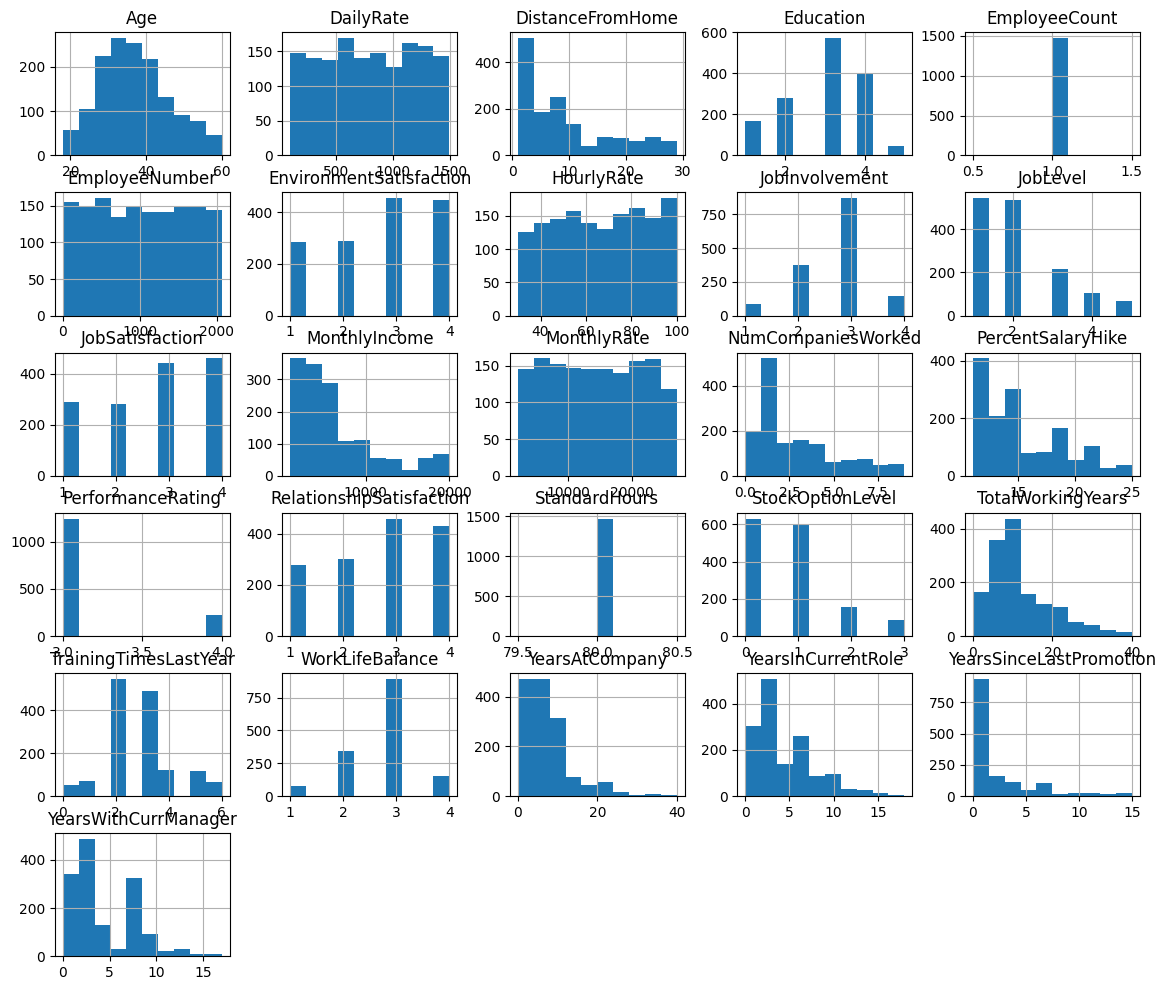

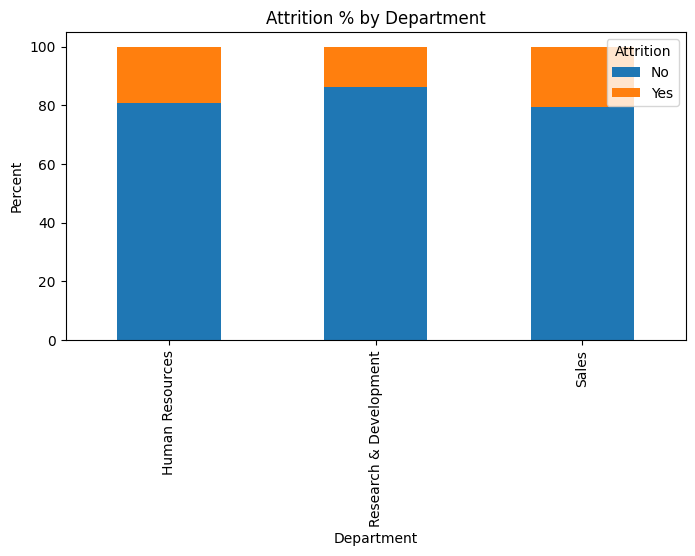

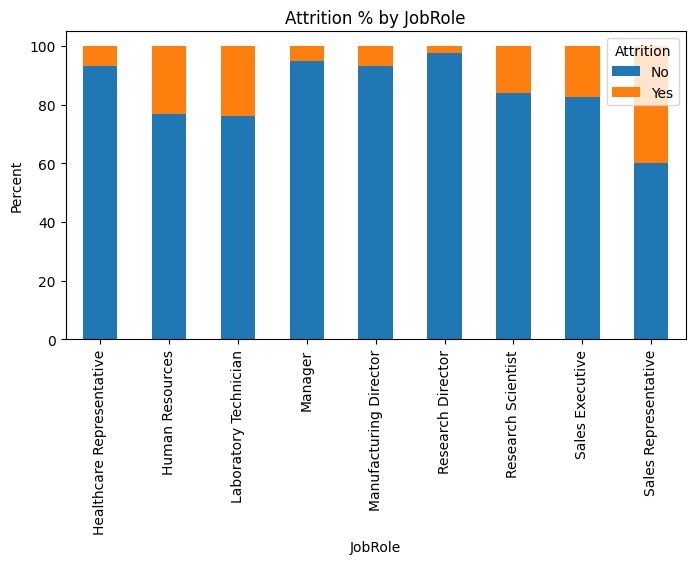

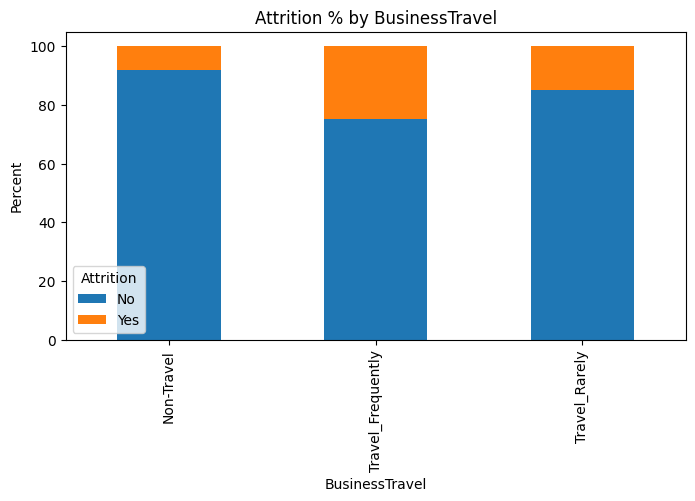

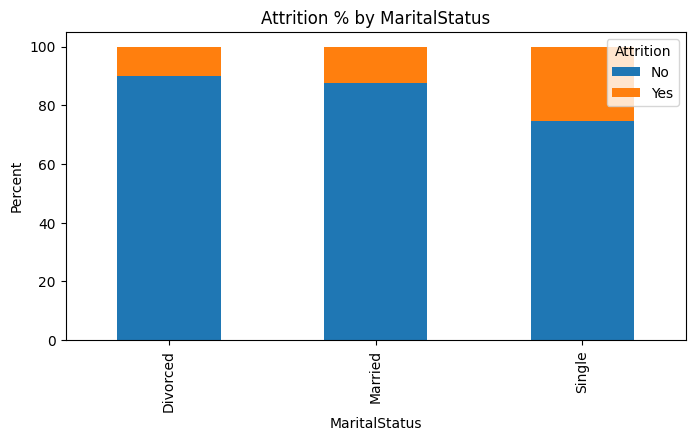

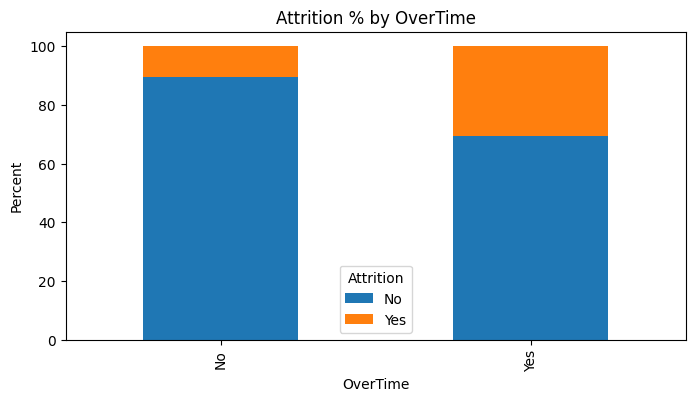

In [35]:
# ---------- Make a PPTX report skeleton ----------
prs = Presentation()
# Title slide
slide = prs.slides.add_slide(prs.slide_layouts[0])
title = slide.shapes.title
subtitle = slide.placeholders[1]
title.text = "HR Attrition Analysis"
subtitle.text = "Auto-generated deck — adjust narrative manually"

# Add EDA slide with a figure
def add_slide_with_image(title_text, img_path):
    slide = prs.slides.add_slide(prs.slide_layouts[5])
    slide.shapes.title.text = title_text
    left = Inches(1)
    top = Inches(1.5)
    slide.shapes.add_picture(img_path, left, top, width=Inches(8))

# Add several key figures (if exist)
img_list = [
    ("Attrition distribution", os.path.join(FIG_DIR, "attrition_count.png")),
    ("Correlation matrix", os.path.join(FIG_DIR, "correlation_matrix.png")),
    ("PCA explained variance", os.path.join(FIG_DIR, "pca_cumulative_explained_variance.png")),
    ("RF top features", os.path.join(FIG_DIR, "rf_top20_importances.png")),
    ("Confusion Matrix (best model)", os.path.join(FIG_DIR, "confusion_RandomForest_PCA.png"))
]
for title_text, img in img_list:
    if os.path.exists(img):
        add_slide_with_image(title_text, img)

prs.save(PPTX_PATH)

print("Done. Results saved in:", RESULT_DIR)
print("Model comparison saved at:", os.path.join(TABLE_DIR, "model_comparison.csv"))
# create directories
for d in [RESULT_DIR, FIG_DIR, MODEL_DIR, TABLE_DIR]:
    Path(d).mkdir(parents=True, exist_ok=True)

# Load data
df = pd.read_csv(DATA_PATH)
# quick save head
df.head().to_csv(os.path.join(TABLE_DIR, "head.csv"), index=False)

# ---------- EDA ----------
def save_fig(fig, name, dpi=150):
    path = os.path.join(FIG_DIR, name)
    fig.savefig(path, bbox_inches="tight", dpi=dpi)
    plt.close(fig)

# 1) Basic info
info = {
    "shape": df.shape,
    "columns": list(df.columns),
    "dtypes": df.dtypes.astype(str).to_dict(),
    "missing_values": df.isna().sum().to_dict(),
    "value_counts_attrition": df["Attrition"].value_counts().to_dict()
}
pd.Series(info).to_json(os.path.join(TABLE_DIR, "dataset_summary.json"))

# 2) Attrition distribution
fig = plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Attrition")
plt.title("Attrition Count")
save_fig(fig, "attrition_count.png")

# 3) Numerical distributions: histograms for numeric columns
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
fig = plt.figure(figsize=(14, 8))
df[num_cols].hist(figsize=(14, 12))
save_fig(fig, "numerical_histograms.png")

# 4) Boxplots of a selection numeric vs Attrition (examples)
for col in ["Age", "DistanceFromHome", "MonthlyIncome", "TotalWorkingYears", "YearsAtCompany"]:
    if col in df.columns:
        fig = plt.figure(figsize=(6,4))
        sns.boxplot(data=df, x="Attrition", y=col)
        plt.title(f"{col} by Attrition")
        save_fig(fig, f"boxplot_{col}_by_attrition.png")

# 5) Categorical relationships: e.g., Department, JobRole, BusinessTravel
cat_cols = df.select_dtypes(include=["object"]).columns.drop("Attrition").tolist()
for col in ["Department", "JobRole", "BusinessTravel", "MaritalStatus", "OverTime"]:
    if col in df.columns:
        fig = plt.figure(figsize=(8,4))
        prop = (pd.crosstab(df[col], df["Attrition"], normalize="index") * 100)
        prop.plot(kind="bar", stacked=True, figsize=(8,4))
        plt.title(f"Attrition % by {col}")
        plt.ylabel("Percent")
        save_fig(fig, f"attrition_by_{col}.png")

# 6) Correlation heatmap (numeric)
corr = df[num_cols].corr()
fig = plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Numeric Correlation Matrix")
save_fig(fig, "correlation_matrix.png")
corr.to_csv(os.path.join(TABLE_DIR, "numeric_correlation.csv"))

# ---------- Prepare data for modeling ----------
# Target
y = (df["Attrition"] == "Yes").astype(int)  # 1 = Yes, 0 = No

# Drop columns that are identifiers or constant
drop_cols = ["EmployeeNumber", "EmployeeCount", "Over18", "StandardHours"]  # adjust if present
X = df.drop(columns=[c for c in drop_cols if c in df.columns] + ["Attrition"])

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE,
                                                    stratify=y)

# Preprocessing pipeline
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

# ---------- Models to try ----------
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=RANDOM_STATE, n_jobs=-1)
}

results = []

def evaluate_model(name, pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:,1] if hasattr(pipeline, "predict_proba") else None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    # confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    save_fig(fig, f"confusion_{name}.png")
    return {"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": roc}

# Train baseline models without PCA
for name, clf in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("clf", clf)])
    pipe.fit(X_train, y_train)
    joblib.dump(pipe, os.path.join(MODEL_DIR, f"{name}_noPCA.pkl"))
    res = evaluate_model(name, pipe, X_test, y_test)
    results.append(res)

# ---------- PCA experiment ----------
# Fit preprocessor, then PCA on numeric+onehot feature-space
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# apply PCA to explain e.g. 0.90 variance
pca = PCA(n_components=0.90, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_trans)
X_test_pca = pca.transform(X_test_trans)

# Scree / explained variance plot
fig = plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance (%)")
plt.title("PCA cumulative explained variance")
save_fig(fig, "pca_cumulative_explained_variance.png")

# Train models on PCA-transformed data (wrap preprocess + PCA inside pipeline)
for name, clf in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("pca", PCA(n_components=0.90, random_state=RANDOM_STATE)),
        ("clf", clf)
    ])
    pipe.fit(X_train, y_train)
    joblib.dump(pipe, os.path.join(MODEL_DIR, f"{name}_withPCA.pkl"))
    res = evaluate_model(name + "_PCA", pipe, X_test, y_test)
    results.append(res)

# Save results table
results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
results_df.to_csv(os.path.join(TABLE_DIR, "model_comparison.csv"), index=False)

# Feature importance for RandomForest (no PCA)
rf_pipe = joblib.load(os.path.join(MODEL_DIR, "RandomForest_noPCA.pkl"))
# get feature names after preprocessing
ohe = rf_pipe.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_names)
importances = rf_pipe.named_steps["clf"].feature_importances_
fi_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)
fi_df.to_csv(os.path.join(TABLE_DIR, "rf_feature_importances.csv"), index=False)

# plot top 20
fig = plt.figure(figsize=(8,6))
sns.barplot(data=fi_df.head(20), x="importance", y="feature")
plt.title("RandomForest Top 20 Feature Importances")
save_fig(fig, "rf_top20_importances.png")

# ---------- Make a PPTX report skeleton ----------
prs = Presentation()
# Title slide
slide = prs.slides.add_slide(prs.slide_layouts[0])
title = slide.shapes.title
subtitle = slide.placeholders[1]
title.text = "HR Attrition Analysis"
subtitle.text = "Auto-generated deck — adjust narrative manually"

# Add EDA slide with a figure
def add_slide_with_image(title_text, img_path):
    slide = prs.slides.add_slide(prs.slide_layouts[5])
    slide.shapes.title.text = title_text
    left = Inches(1)
    top = Inches(1.5)
    slide.shapes.add_picture(img_path, left, top, width=Inches(8))

# Add several key figures (if exist)
img_list = [
    ("Attrition distribution", os.path.join(FIG_DIR, "attrition_count.png")),
    ("Correlation matrix", os.path.join(FIG_DIR, "correlation_matrix.png")),
    ("PCA explained variance", os.path.join(FIG_DIR, "pca_cumulative_explained_variance.png")),
    ("RF top features", os.path.join(FIG_DIR, "rf_top20_importances.png")),
    ("Confusion Matrix (best model)", os.path.join(FIG_DIR, "confusion_RandomForest_PCA.png"))
]
for title_text, img in img_list:
    if os.path.exists(img):
        add_slide_with_image(title_text, img)

prs.save(PPTX_PATH)

print("Done. Results saved in:", RESULT_DIR)
print("Model comparison saved at:", os.path.join(TABLE_DIR, "model_comparison.csv"))
